<a href="https://colab.research.google.com/github/plaban1981/NLP_Transformers/blob/main/Sentiment_Classification_Model_with_Tensorflow_and_Transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Dataset : Rotten Tomatoes movie reviews dataset.
https://www.kaggle.com/c/sentiment-analysis-on-movie-reviews/data

https://github.com/jamescalam/transformers/tree/main/course/language_classification

## Retrieve Data using Kaggle API

* . Install the Kaggle library

In [1]:
!pip install kaggle

* Upload kaggle.json

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"plabannayak","key":"f1f19a1783935d871fc0049a716ef3a8"}'}

* Make a directory named “.kaggle”

In [3]:
!mkdir -p ~/.kaggle

* Copy the “kaggle.json” into this new directory

In [4]:
! cp kaggle.json ~/.kaggle/

* Allocate the required permission for this file.

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

## Import kaggle library

In [6]:
import kaggle

## Use Kaggle Api to download data

In [7]:
from kaggle.api.kaggle_api_extended import KaggleApi
import zipfile
import os

api = KaggleApi()
api.authenticate()

for file in ['train.tsv', 'test.tsv']:
    api.competition_download_file('sentiment-analysis-on-movie-reviews', f'{file}.zip', path='./')

    with zipfile.ZipFile(f'{file}.zip', 'r') as zip_ref:
        zip_ref.extractall('./')

    os.remove(f'{file}.zip')

100%|██████████| 1.28M/1.28M [00:00<00:00, 109MB/s]

100%|██████████| 494k/494k [00:00<00:00, 104MB/s]

## Preparing Data
*We will start by reading the data into a Pandas Dataframe using th read_csv function. Because we're working with .tsv (tab seperate values) files we need to specify that we will be taking tab characters as the delimiters:*

In [8]:
import pandas as pd
df = pd.read_csv("/content/train.tsv",sep="\t")
df.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [12]:
df.shape

(156060, 4)

* The Phrase column contains all of our text data that we will be processing. 
* We can also see that there are many copies through segments of the same answer (note that the SentenceId value for each of these copies is identical). 
* We can reduce the amount of noise in our dataset by removing these duplicates.

## Check the distribution of sentiment classes across our data.

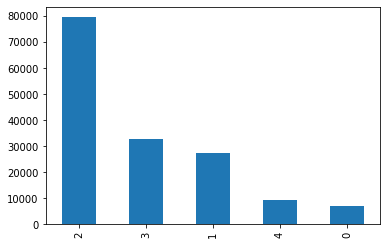

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
df['Sentiment'].value_counts().plot(kind='bar')

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


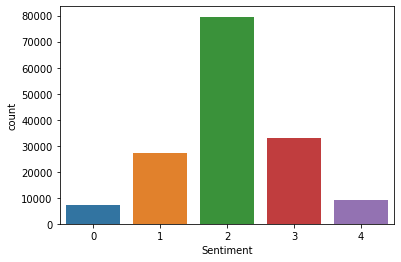

In [3]:
sns.countplot(df['Sentiment'])

In [9]:
import numpy as np
seq_len = 512
num_samples = len(df)
num_samples,seq_len

(156060, 512)

#### Tokenize the input 

* create two input tensors :input IDs, and attention mask
* 512 is the sequence length of our tokenized sequences for BERT
* len(df) is the number of samples in our dataset.

### Install Transformers

In [10]:
!pip install transformers

     |████████████████████████████████| 3.1 MB 4.2 MB/s 
     |████████████████████████████████| 3.3 MB 55.5 MB/s 
     |████████████████████████████████| 59 kB 8.6 MB/s 
     |████████████████████████████████| 596 kB 65.0 MB/s 
     |████████████████████████████████| 895 kB 70.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [11]:
from transformers import BertTokenizer
# initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
# tokenize - this time returning Numpy tensors
tokens = tokenizer(df['Phrase'].tolist(),
                   max_length=seq_len, 
                   truncation=True,
                   padding='max_length', 
                   add_special_tokens=True,
                   return_tensors='np')

Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [13]:
tokens

{'input_ids': array([[  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       [  101,   138,  1326, ...,     0,     0,     0],
       ...,
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101,   170, 25247, ...,     0,     0,     0],
       [  101, 22572, 12148, ...,     0,     0,     0]]), 'token_type_ids': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]]), 'attention_mask': array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]])}

In [15]:
tokens.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

## Save the tokens as as Numpy binary files:

In [14]:
import gc
gc.collect()

459

In [16]:
with open('movie-input-ids.npy','wb') as f:
  np.save(f,tokens['input_ids'])
#
with open('movie-attention-mask.npy','wb') as f:
  np.save(f,tokens['attention_mask'])

##  we can delete the in-memory arrays to free up memory.

In [17]:
del tokens

*Presently our target data is a set of integer values (representing sentiment classes) in the Sentiment column of our dataframe df. We need to extract these values and one-hot encode them into another numpy array, which will have the dimensions len(df) * number of label classes.*

In [15]:
# first extract sentiment column
arr = df['Sentiment'].values

In [16]:
arr

array([1, 2, 2, ..., 3, 2, 2])

In [17]:
np.unique(arr)

array([0, 1, 2, 3, 4])

*In our Sentiment column, there are five unique labels which means we need our labels array to have five columns (one for each) - arr.max() = 4, so we do 4 + 1 to get our required value of 5.*

In [18]:
# we then initialize the zero array
labels = np.zeros((num_samples, arr.max()+1))
labels.shape

(156060, 5)

*Now we use the current values in our arr of [0, 1, 2, 3, 4] to place 1 values in the correct positions of our presently zeros-only array:*

In [19]:
arr

array([1, 2, 2, ..., 3, 2, 2])

In [20]:
labels

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0.]])

In [21]:
labels[np.arange(num_samples),arr]  = 1

In [22]:
labels

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

## Save the lables to file as a Numpy binary file.

In [26]:
with open('movie-labels.npy', 'wb') as f:
  np.save(f,labels)

## Input Pipeline

In [5]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
import shutil
shutil.move("/content/movie-input-ids.npy","/content/drive/MyDrive/NLP_RAM/James_Briggs")

'/content/drive/MyDrive/NLP_RAM/James_Briggs/movie-input-ids.npy'

In [7]:
shutil.move("/content/movie-labels.npy","/content/drive/MyDrive/NLP_RAM/James_Briggs")

'/content/drive/MyDrive/NLP_RAM/James_Briggs/movie-labels.npy'

In [8]:
shutil.move("/content/movie-attention-mask.npy","/content/drive/MyDrive/NLP_RAM/James_Briggs")

'/content/drive/MyDrive/NLP_RAM/James_Briggs/movie-attention-mask.npy'

*As we're using TensorFlow we can make use of the tf.data.Dataset object. First, we'll load in our Numpy binaries from file:*

In [9]:
import numpy as np
with open('/content/drive/MyDrive/NLP_RAM/James_Briggs/movie-input-ids.npy', 'rb') as f:
    Xids = np.load(f, allow_pickle=True)
with open('/content/drive/MyDrive/NLP_RAM/James_Briggs/movie-attention-mask.npy', 'rb') as f:
    Xmask = np.load(f, allow_pickle=True)
with open('/content/drive/MyDrive/NLP_RAM/James_Briggs/movie-labels.npy', 'rb') as f:
    labels = np.load(f, allow_pickle=True)

*We can take these three arrays and create a TF dataset object with them using from_tensor_slices like so:*

In [23]:
import tensorflow as tf
dataset = tf.data.Dataset.from_tensor_slices((tokens['input_ids'], tokens['attention_mask'], labels))
dataset.take(1)

<TakeDataset shapes: ((512,), (512,), (5,)), types: (tf.int64, tf.int64, tf.float64)>

*Each sample in our dataset is a tuple containing a single Xids**, **Xmask**, and **labels tensor**. *

*However, when feeding data into our model we need a two-item tuple in the format (\<inputs>, \<outputs>).*

*Now, we have two tensors for our inputs - so, what we do is enter our \<inputs> tensor as a dictionary:*



{
    
    'input_ids': <input_id_tensor>,

    'attention_mask': <mask_tensor>
}


* To rearrange the dataset format we can map a function that modifies the format like so:

In [24]:
def map_func(input_ids, masks, labels):
    # we convert our three-item tuple into a two-item tuple where the input item is a dictionary
    return {'input_ids': input_ids, 'attention_mask': masks}, labels

# then we use the dataset map method to apply this transformation
dataset = dataset.map(map_func)

dataset.take(1)

<TakeDataset shapes: ({input_ids: (512,), attention_mask: (512,)}, (5,)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

## Dataset Shuffle, Batch,Split and Save

##  Shuffle our data, and batch it. We will take batch sizes of 16 and drop any samples that don't fit evenly into chunks of 16.

In [25]:
batch_size = 32
dataset = dataset.shuffle(10000).batch(batch_size, drop_remainder=True)
dataset.take(1)

<TakeDataset shapes: ({input_ids: (32, 512), attention_mask: (32, 512)}, (32, 5)), types: ({input_ids: tf.int64, attention_mask: tf.int64}, tf.float64)>

*Now our dataset samples are organized into batches of 16. The final step is to split our data into training and validation sets. For this we use the take and skip methods, creating and 90-10 split.*

In [13]:
Xids.shape[0] 

156060

In [27]:
len(tokens['input_ids'])

156060

In [53]:
Xids.shape[0] / batch_size

9753.75

In [28]:
split = 0.9
# we need to calculate how many batches must be taken to create 90% training set
size = int((len(tokens['input_ids']) / batch_size) * split) # int i used for whole numbers as a result
size

4389

*Our two datasets are fully prepared for our model inputs. Now, we can save both to file using tf.data.experimental.save.*

In [29]:
train_ds = dataset.take(size)
val_ds = dataset.skip(size) #sikp method to skip thre required records

# free up memory
del dataset

In [16]:
import tensorflow as tf
tf.data.experimental.save(train_ds, 'train')
tf.data.experimental.save(val_ds, 'val')

In [17]:
train_ds.element_spec # describes the data set

({'attention_mask': TensorSpec(shape=(8, 512), dtype=tf.int64, name=None),
  'input_ids': TensorSpec(shape=(8, 512), dtype=tf.int64, name=None)},
 TensorSpec(shape=(8, 5), dtype=tf.float64, name=None))

In [18]:
val_ds.element_spec ==  train_ds.element_spec 

True

##  loading Data 

*loading these files using tf.data.experimental.load.*

In [11]:
ds = tf.data.experimental.load('train', element_spec=train_ds.element_spec)

## Build and Train sentiment classifier 

In [30]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

# we can view the model using the summary method
bert.summary()

Downloading:   0%|          | 0.00/502M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bert (TFBertMainLayer)      multiple                  108310272 
                                                                 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


## Define a frame (input head) around Bert, we need:

* Two input layers (one for input IDs and one for attention mask).

* A post-bert dropout layer to reduce the likelihood of overfitting and improve generalization.

* Max pooling layer to convert the 3D tensors output by Bert to 2D.

* [link text](https://)Final output activations using softmax for outputting categorical probabilities.

In [31]:
import tensorflow as tf

# two input layers, we ensure layer name variables match to dictionary keys in TF dataset
input_ids = tf.keras.layers.Input(shape=(512,), name='input_ids', dtype='int32')
mask = tf.keras.layers.Input(shape=(512,), name='attention_mask', dtype='int32')

# we access the transformer model within our bert object using the bert attribute (eg bert.bert instead of bert)
embeddings = bert.bert(input_ids, attention_mask=mask)[1]  # access final activations (alread max-pooled) [1]
# convert bert embeddings into 5 output classes
x = tf.keras.layers.Dense(1024, activation='relu')(embeddings)
y = tf.keras.layers.Dense(5, activation='softmax', name='outputs')(x)

## Define our model, specifying input and output layers. 

* Finally, we can freeze the Bert layer because Bert is already highly trained, and contains a huge number of parameters so will take a very long time to train further. 

* Nonetheless, if you'd like to train Bert too, there is nothing wrong with doing so.

In [32]:
# initialize model
model = tf.keras.Model(inputs=[input_ids, mask], outputs=y)

# (optional) freeze bert layer
model.layers[2].trainable = False

# print out model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_ids (InputLayer)         [(None, 512)]        0           []                               
                                                                                                  
 attention_mask (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 bert (TFBertMainLayer)         TFBaseModelOutputWi  108310272   ['input_ids[0][0]',              
                                thPoolingAndCrossAt               'attention_mask[0][0]']         
                                tentions(last_hidde                                               
                                n_state=(None, 512,                                           

## Initialize other training parameters

In [33]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5, decay=1e-6)
loss = tf.keras.losses.CategoricalCrossentropy()
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')

model.compile(optimizer=optimizer, loss=loss, metrics=[acc])

*Now all we need to do is train our model. For this, we need to load in our training and validation datasets - which also requires our dataset element specs to be defined.*

In [28]:
element_spec = ({'input_ids': tf.TensorSpec(shape=(16, 512), dtype=tf.float64, name=None),
                 'attention_mask': tf.TensorSpec(shape=(16, 512), dtype=tf.float64, name=None)},
                tf.TensorSpec(shape=(16, 5), dtype=tf.float64, name=None))

# load the training and validation sets
train_ds = tf.data.experimental.load('/content/train', element_spec=element_spec)
val_ds = tf.data.experimental.load('/content/val', element_spec=element_spec)

# view the input format
train_ds.take(1)

<TakeDataset shapes: ({input_ids: (16, 512), attention_mask: (16, 512)}, (16, 5)), types: ({input_ids: tf.float64, attention_mask: tf.float64}, tf.float64)>

## Train The Model

In [34]:
history = model.fit(train_ds,validation_data=val_ds,epochs=1)

4389/4389 [==============================] - 3630s 825ms/step - loss: 1.1702 - accuracy: 0.5323 - val_loss: 1.1475 - val_accuracy: 0.5230
